41260 41260 21405 21405


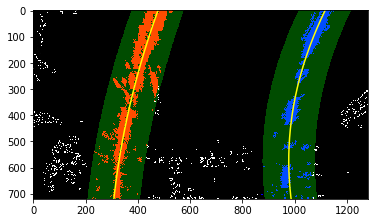

In [4]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

base_dir = 'Adv_CV/AdvCV/Histogram_Peaks'

# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread(os.path.join(base_dir, 'warped_example.jpg'))

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([2.85485065e-04, -4.21909310e-01, 4.75971327e+02])
right_fit = np.array([3.58429155e-04, -4.60104531e-01, 1.11376056e+03])
# left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
# right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    # print(binary_warped.shape[1], left_fitx.shape, len(ploty))

    left_lane_inds = []
    right_lane_inds = []
    for i in range(len(ploty)):
        y_mask = np.array(nonzeroy == ploty[i])
        xleft_mask = np.array((nonzerox >= left_fitx[i] - margin) & 
                              (nonzerox < left_fitx[i] + margin))
        xright_mask = np.array((nonzerox >= right_fitx[i] - margin) & 
                                (nonzerox < right_fitx[i] + margin))                     
        left_lane_inds.append((nonzeroy[y_mask & xleft_mask], 
                               nonzerox[y_mask & xleft_mask]))
        right_lane_inds.append((nonzeroy[y_mask & xright_mask], 
                                nonzerox[y_mask & xright_mask]))
    
    # Again, extract left and right line pixel positions
    leftx = np.concatenate([it[1] for it in left_lane_inds])
    lefty = np.concatenate([it[0] for it in left_lane_inds]) 
    rightx = np.concatenate([it[1] for it in right_lane_inds])
    righty = np.concatenate([it[0] for it in right_lane_inds])
    print(len(leftx), len(lefty), len(rightx), len(righty))
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)